<a href="https://colab.research.google.com/github/lima-breno/time_series/blob/main/TS_10_Sazonais_SARIMA_passageiros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelos sazonais: SARIMA

Este notebook busca uma série temporal de um arquivo escolhido e faz algumas análises preliminares, bem como a aplicação dos modelos SARIMA.

Data da última atualização: 10/03/2025

#### Preliminares

In [ ]:
# Carregamento das bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Ajuste das preferências gráficas

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#FFFFFF',    # Cor da moldura
    'axes.facecolor': '#FFFFFF',      # Cor do fundo
    'savefig.facecolor':'#000000',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'grid.color': '#888888',
    'grid.linewidth': '0.1',
    'text.color': '#000000',
    'axes.labelcolor': '#000000',
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (21,13)

#### Carregamento da Série Temporal

In [ ]:
# Leitura do arquivo de dados

MinhaSerieTemporal = pd.read_csv('Passageiros.csv', index_col = 0)

In [ ]:
# Exibição do DataFrame

MinhaSerieTemporal

,Passageiros (milhares)
Mês,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [ ]:
# Ajuste do índice para formato DateTime

MinhaSerieTemporal.index = pd.to_datetime(MinhaSerieTemporal.index)

<Axes: xlabel='Mês'>

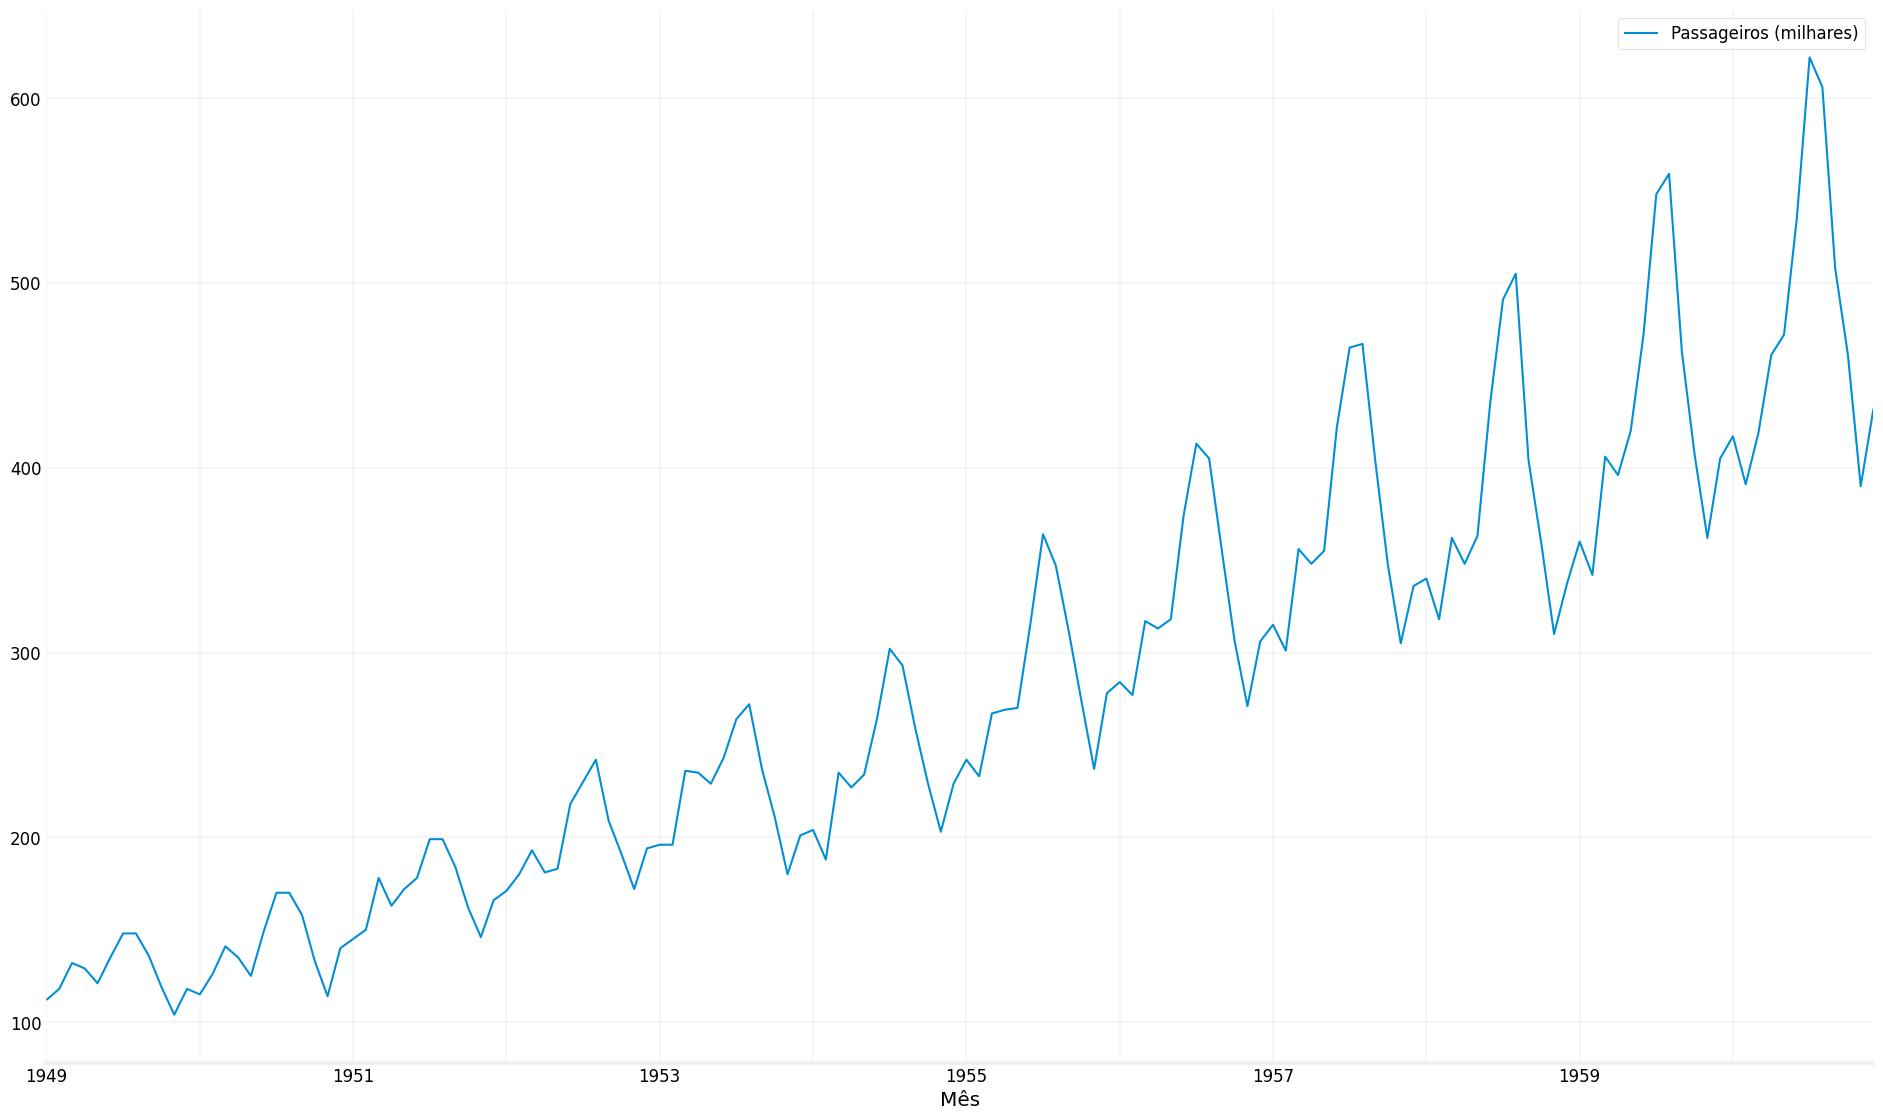

In [ ]:
# Gráfico
MinhaSerieTemporal.plot()

#### Decomposição da Série

In [ ]:
# Decomposição aditiva da série temporal

PeriodoSazonal = 12     # Sazonalidade anual

Decomposicao = seasonal_decompose(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], model = "add", period = PeriodoSazonal)

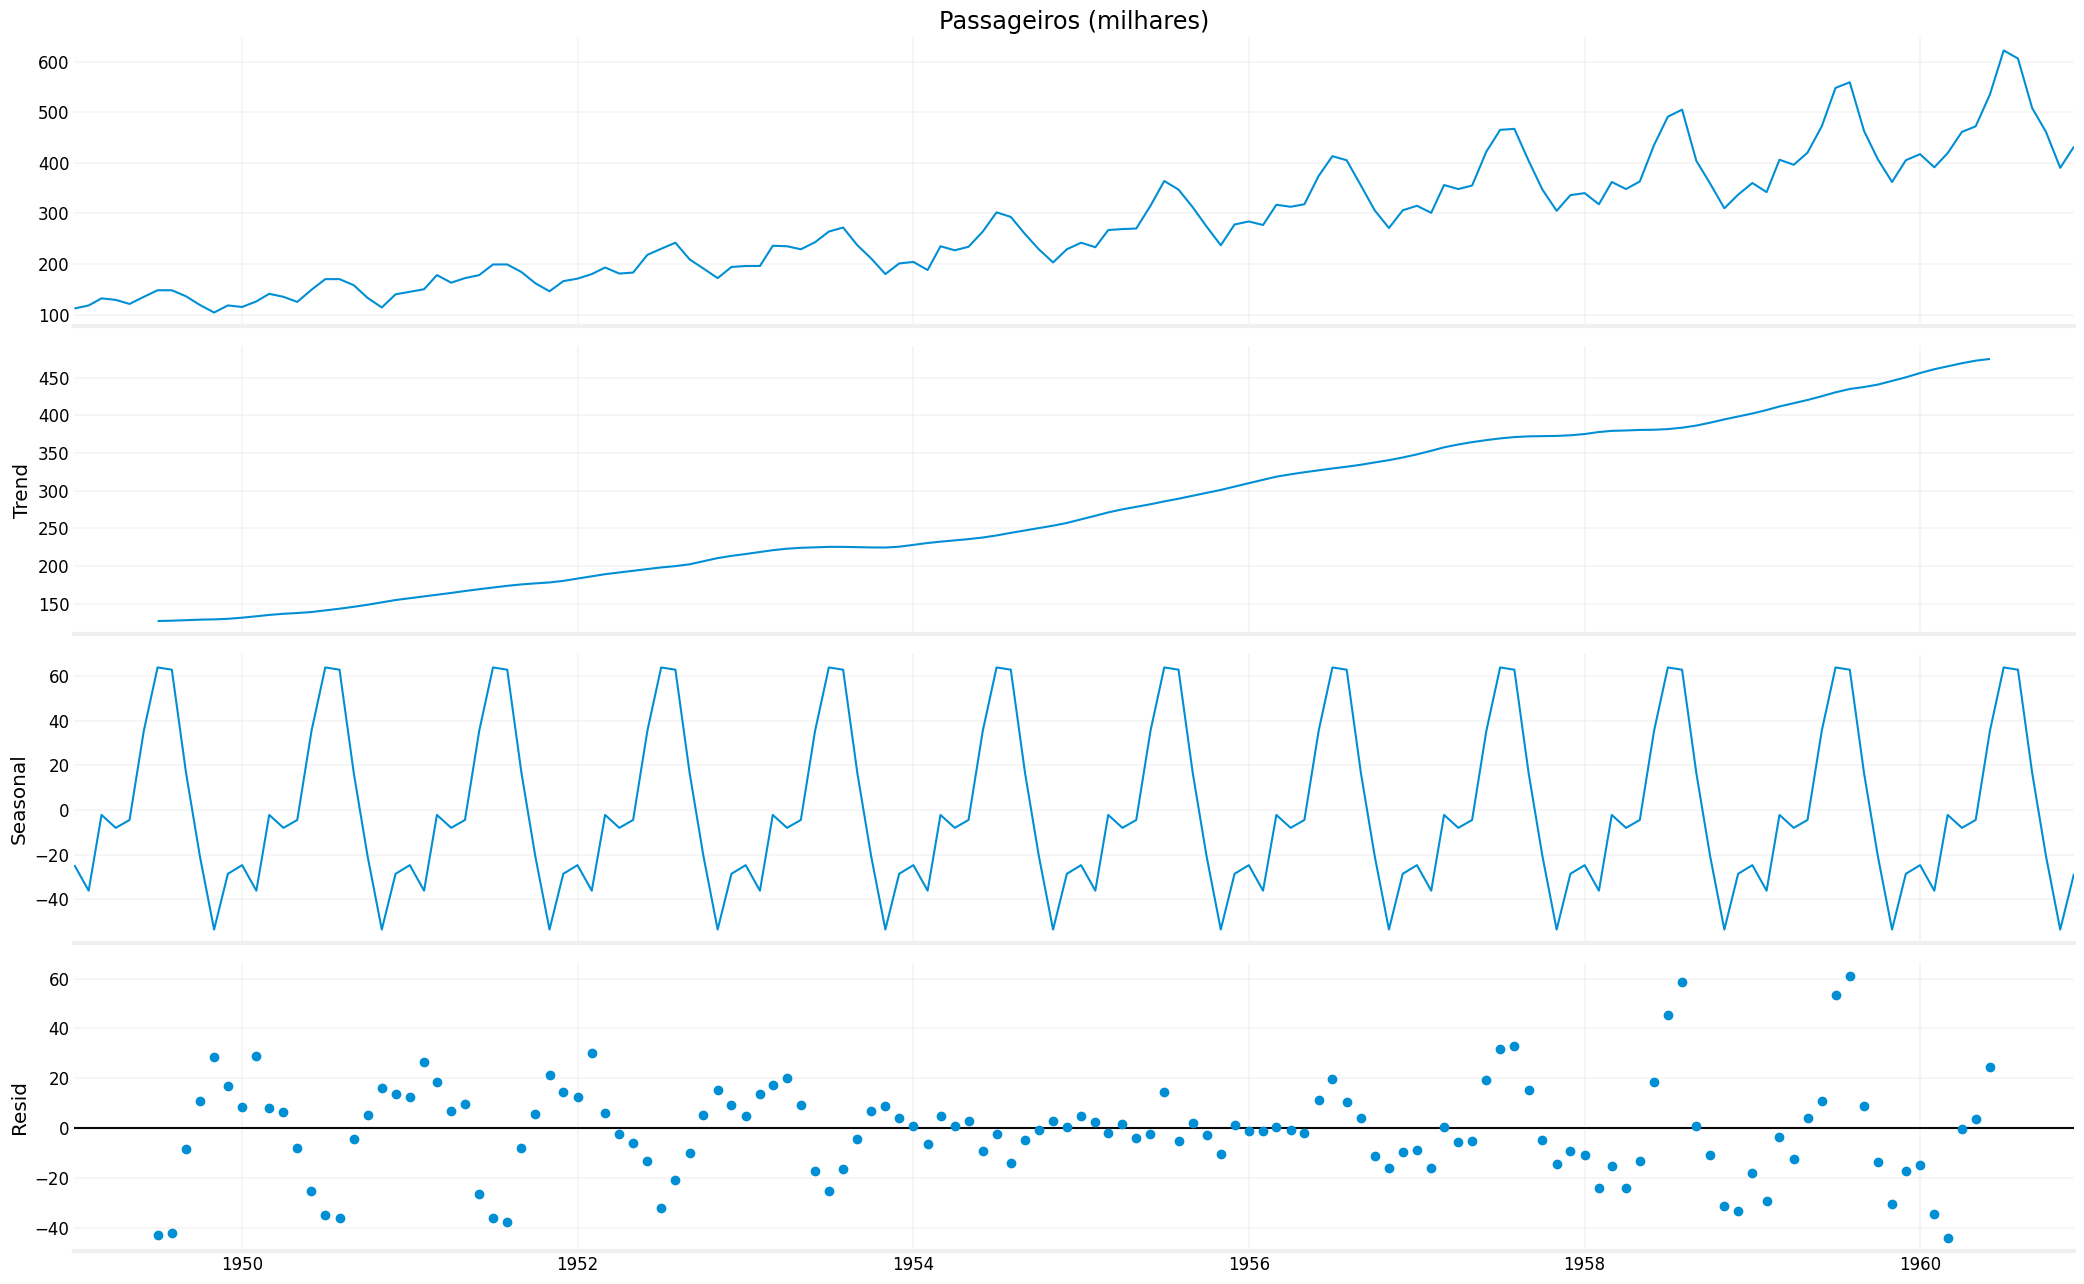

In [ ]:
Decomposicao.plot();

#### Teste ADF

In [ ]:
# Teste ADF para estacionariedade

ad_fuller_result = adfuller(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]])

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: 0.8154
p-value:          99.1880 %


In [ ]:
# Teste ADF para estacionariedade para a série das diferenças finitas de ordem escolhida

OrdemDif = 1

ad_fuller_result = adfuller(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif))

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: -2.8293
p-value:          5.4213 %


In [ ]:
# Teste ADF para estacionariedade para a série das diferenças finitas de ordem escolhida

OrdemDif = 2

ad_fuller_result = adfuller(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif))

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: -16.3842
p-value:          0.0000 %


#### Funcão de autocorrelação

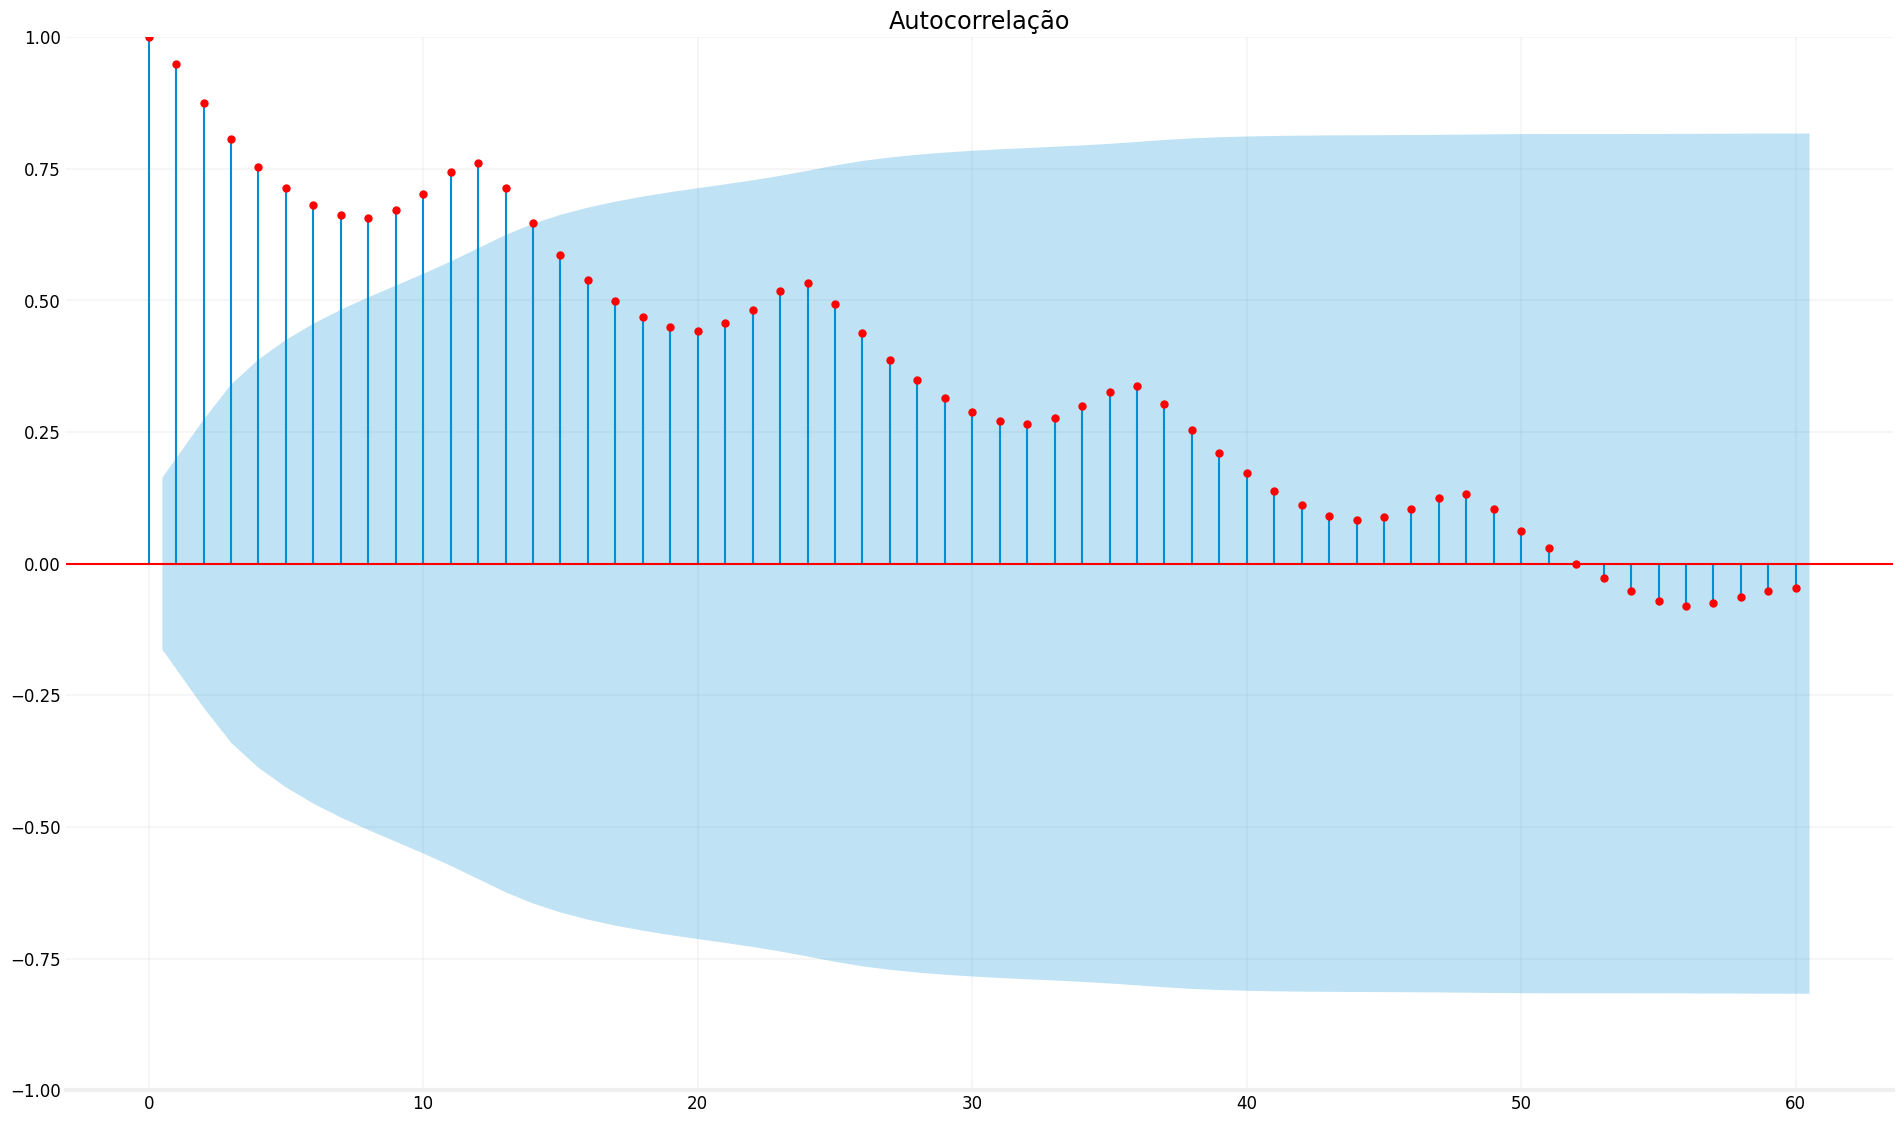

In [ ]:
# Função de correlação para série temporal

plot_acf(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]],  lags=60, title = "Autocorrelação", color="red");

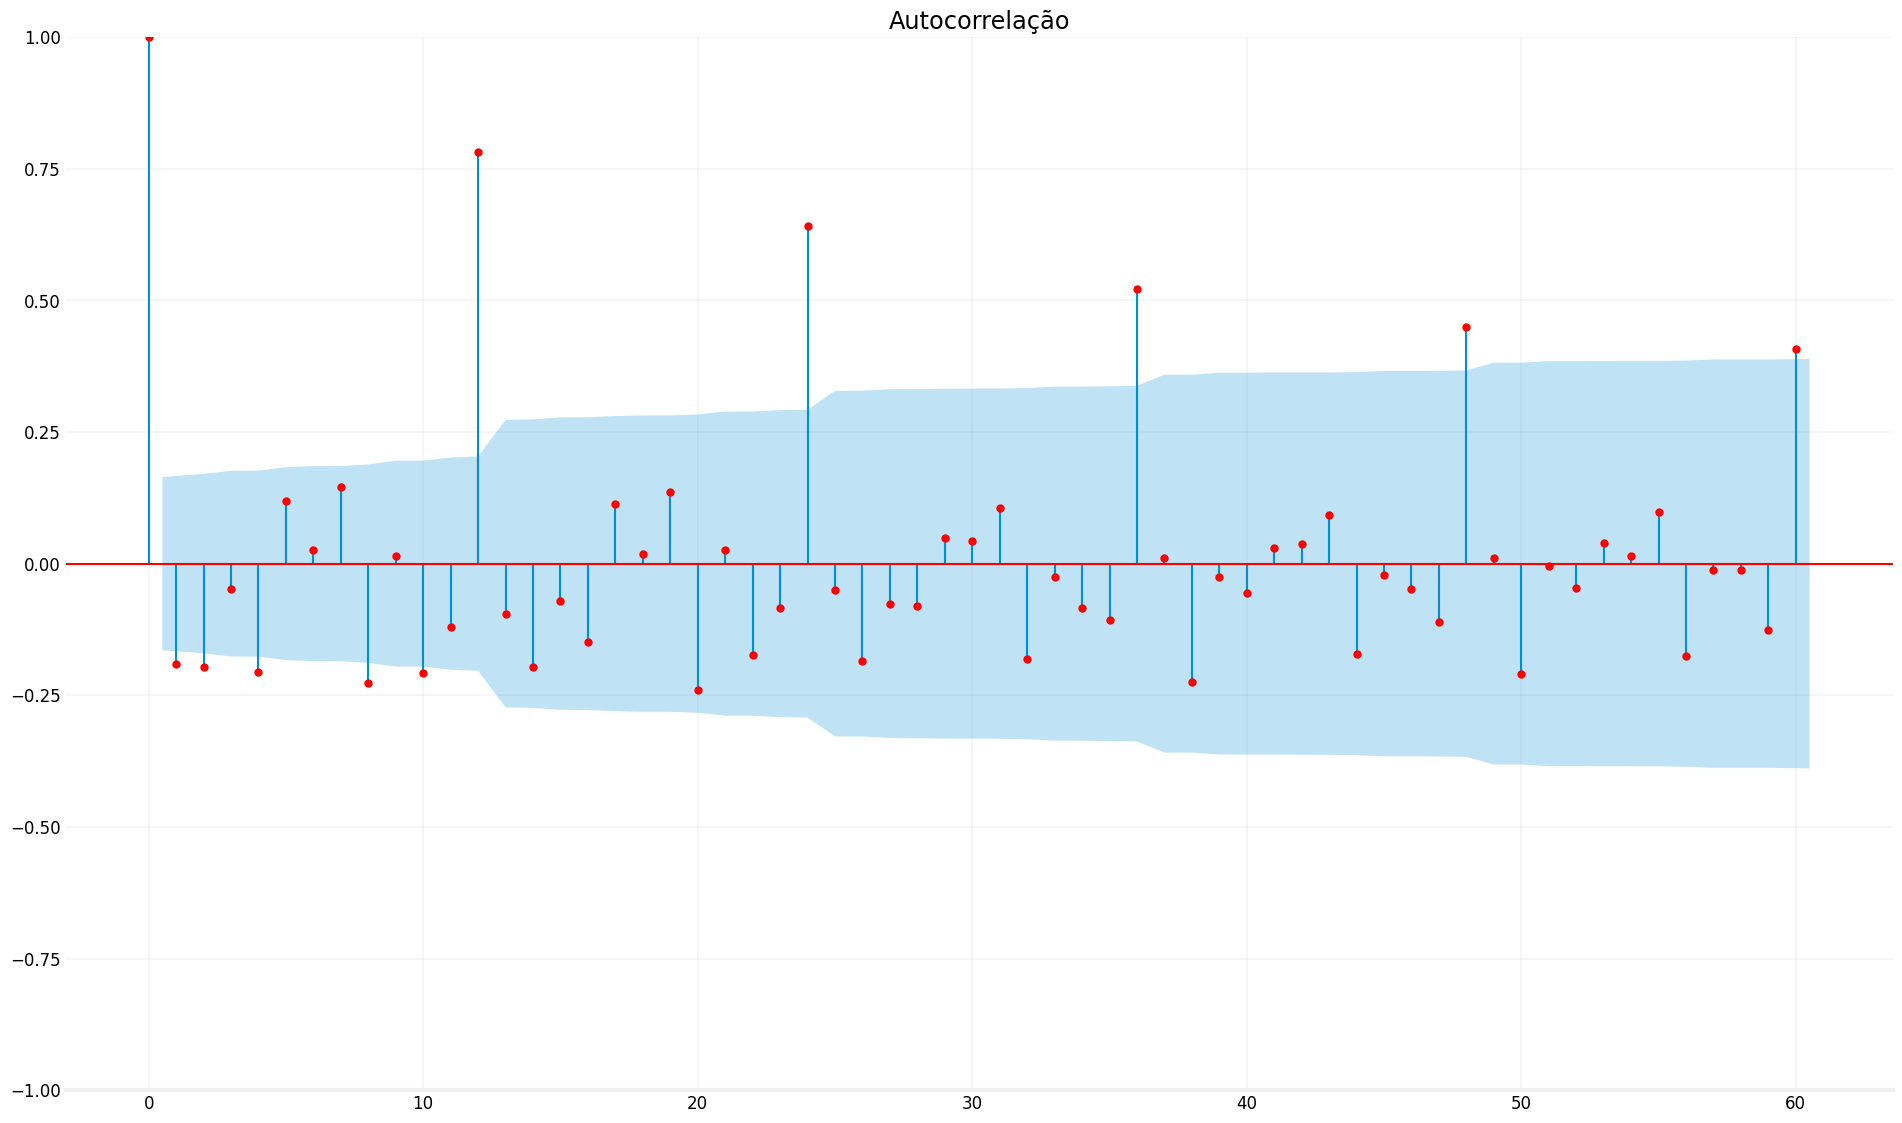

In [ ]:
# Função de correlação para série das diferenças finitas da ordem escolhida acima

plot_acf(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif),  lags=60, title = "Autocorrelação", color="red");

#### Funcão de autocorrelação parcial

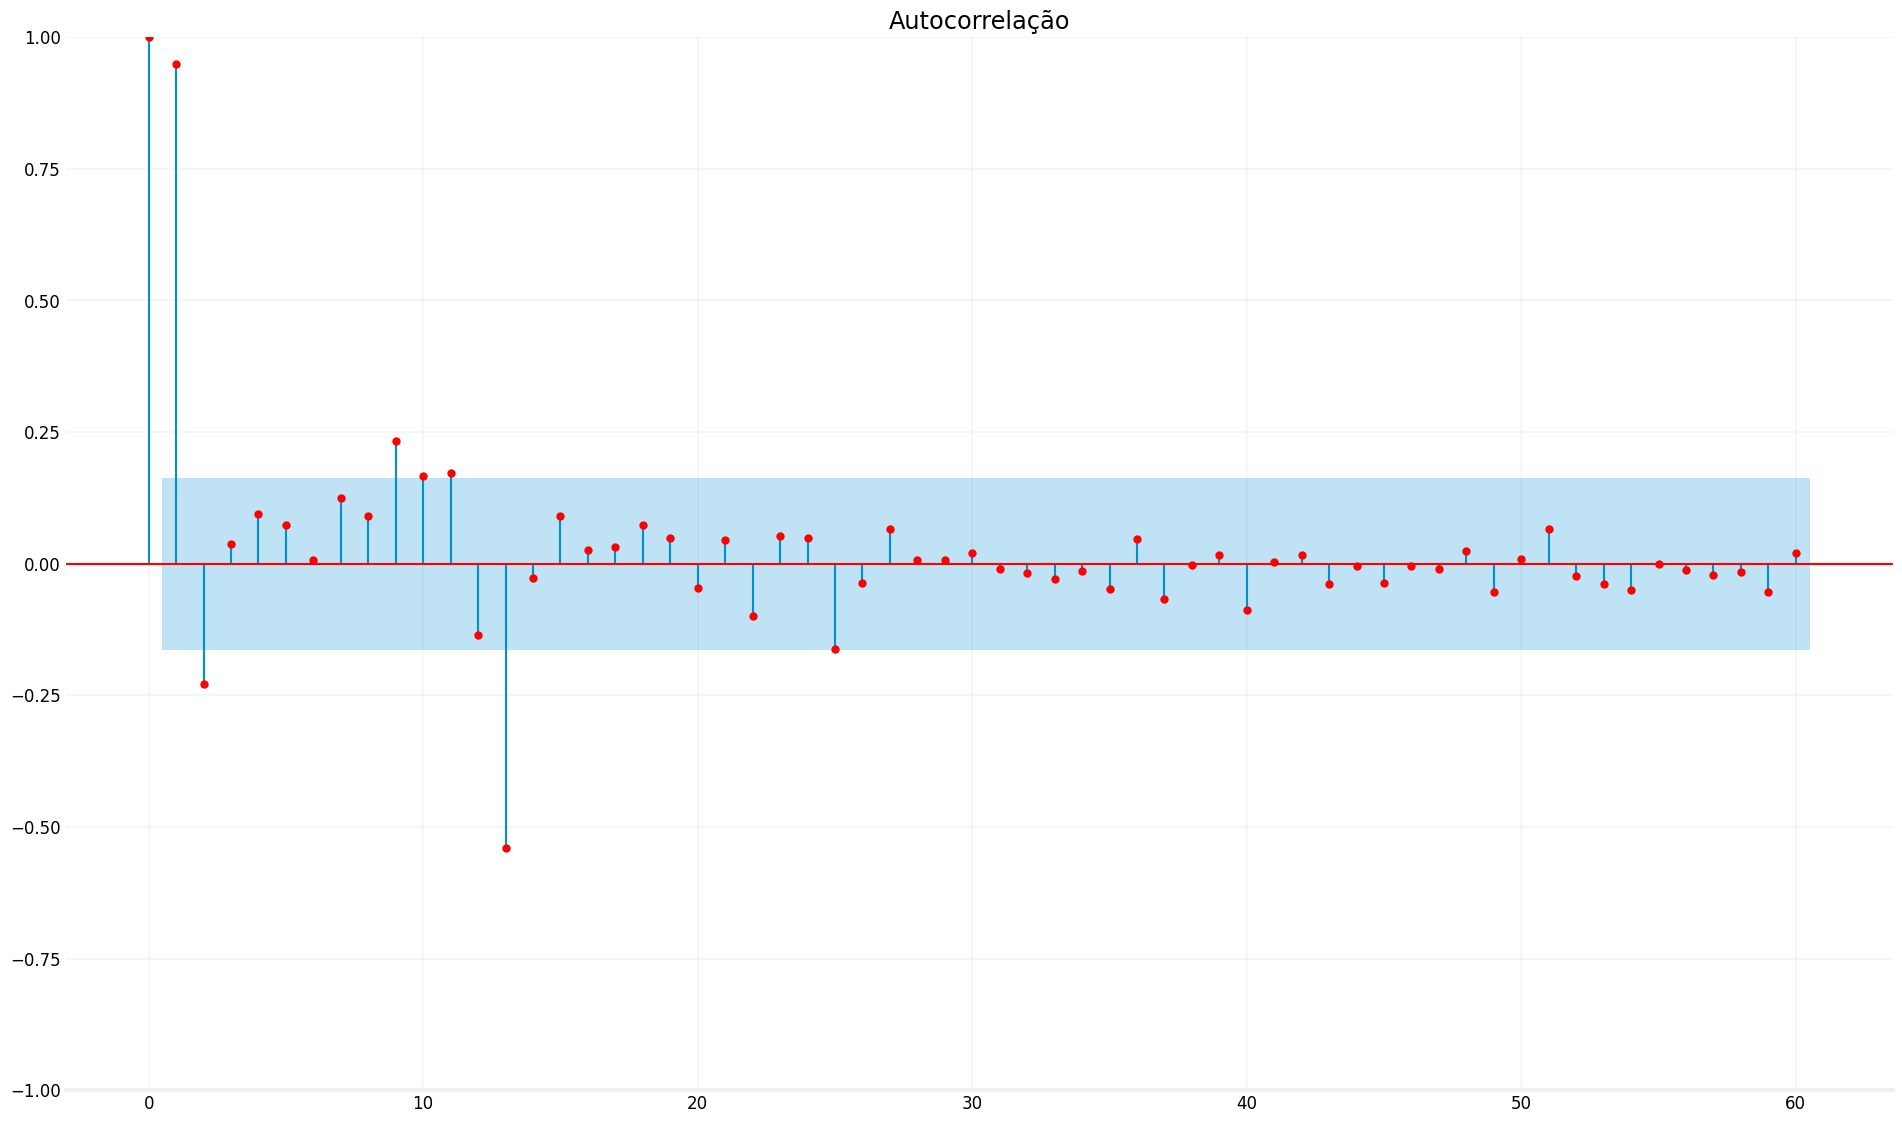

In [ ]:
# Função de correlação parcial para série temporal

plot_pacf(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]],  lags=60, title = "Autocorrelação", color="red");

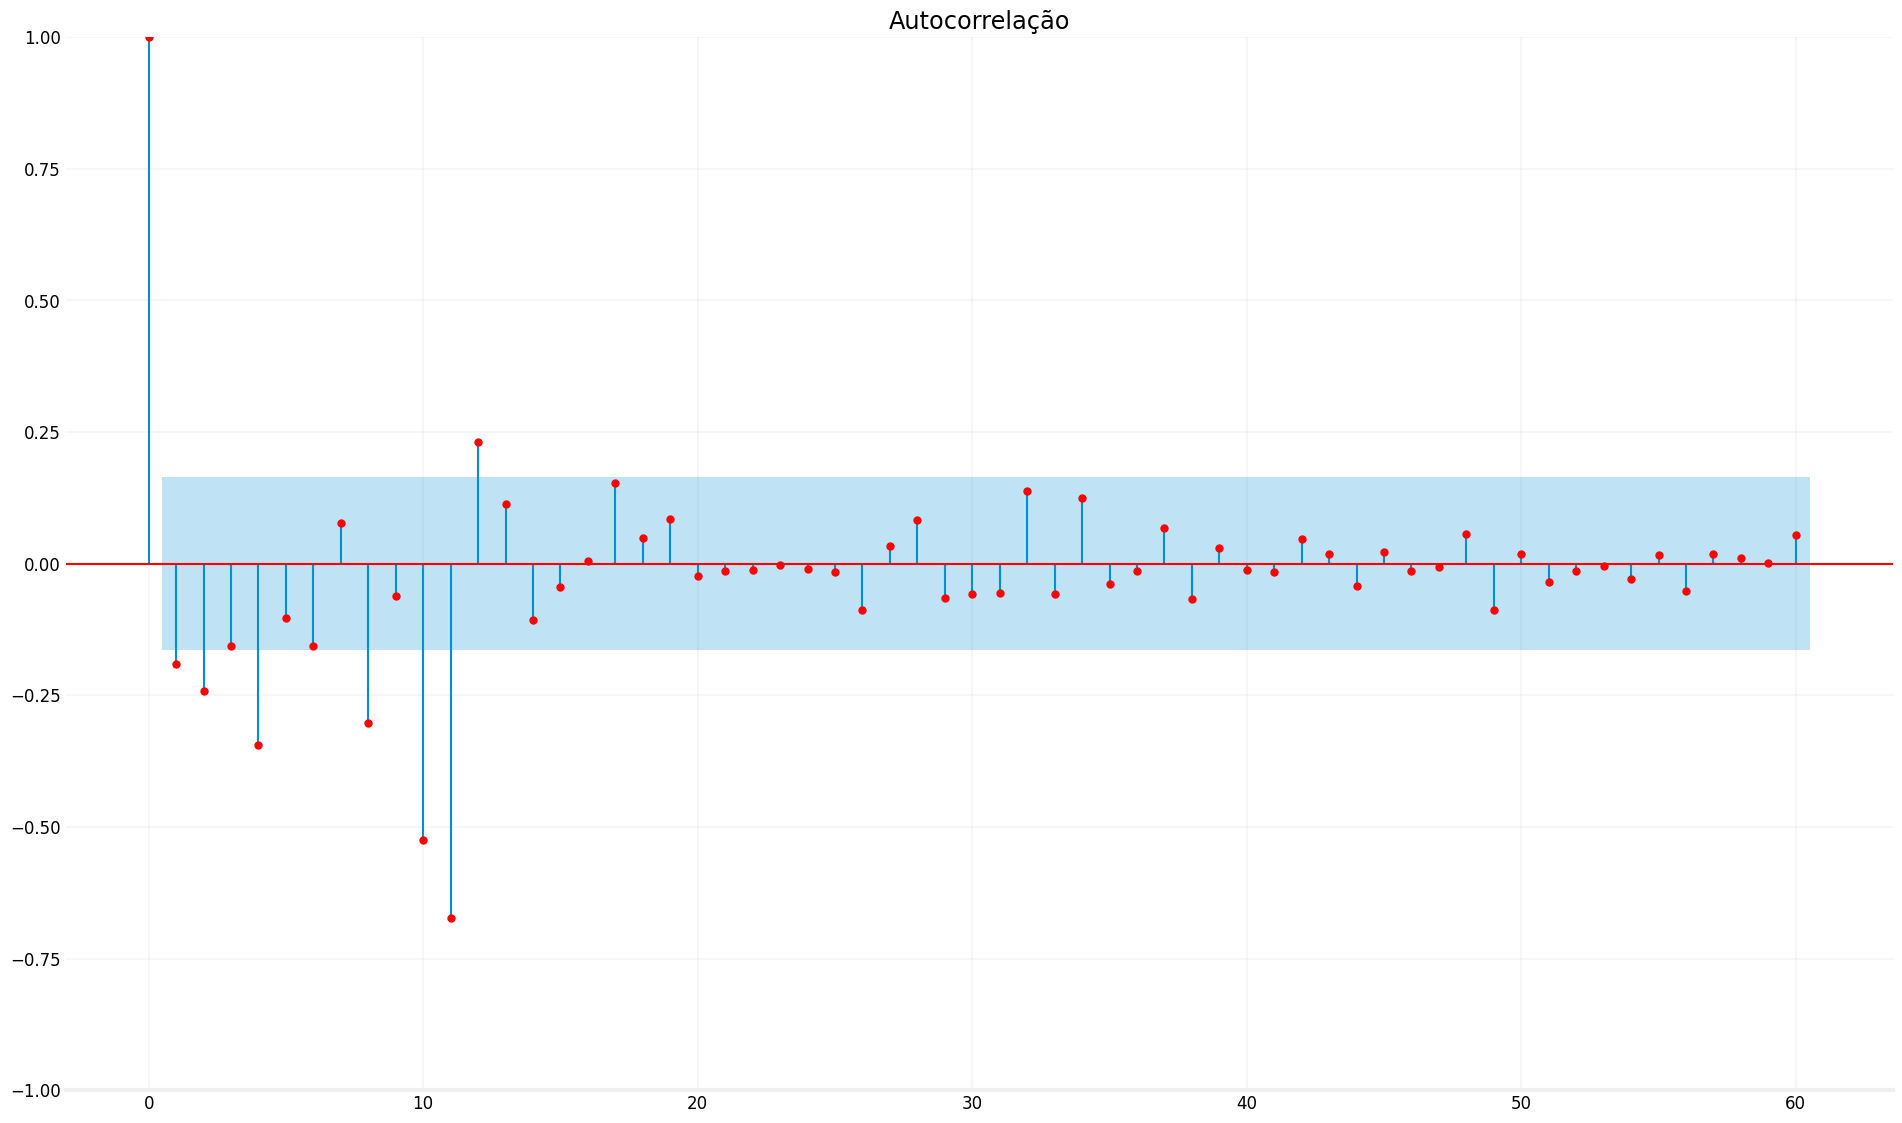

In [ ]:
# Função de correlação parcial para série das diferenças finitas da ordem escolhida acima

plot_pacf(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif),  lags=60, title = "Autocorrelação", color="red");

#### Separação das bases de treino e teste

In [ ]:
# Definição da proporção de dados para compor a base de teste

PercentualTeste = 10

In [ ]:
# Cálculo do tamanho do período de testes
PeriodoTeste = PercentualTeste * len(MinhaSerieTemporal) // 100

# Definição do DataFrame de treino
TreinoDF = pd.DataFrame(index = MinhaSerieTemporal[:-PeriodoTeste].index)
TreinoDF['Treino'] = MinhaSerieTemporal[:-PeriodoTeste][MinhaSerieTemporal.columns[0]]

# Definição do DataFrame de teste
TesteDF  = pd.DataFrame(index = MinhaSerieTemporal[-PeriodoTeste:].index)
TesteDF['Teste'] = MinhaSerieTemporal[-PeriodoTeste:][MinhaSerieTemporal.columns[0]]

<Axes: xlabel='Mês'>

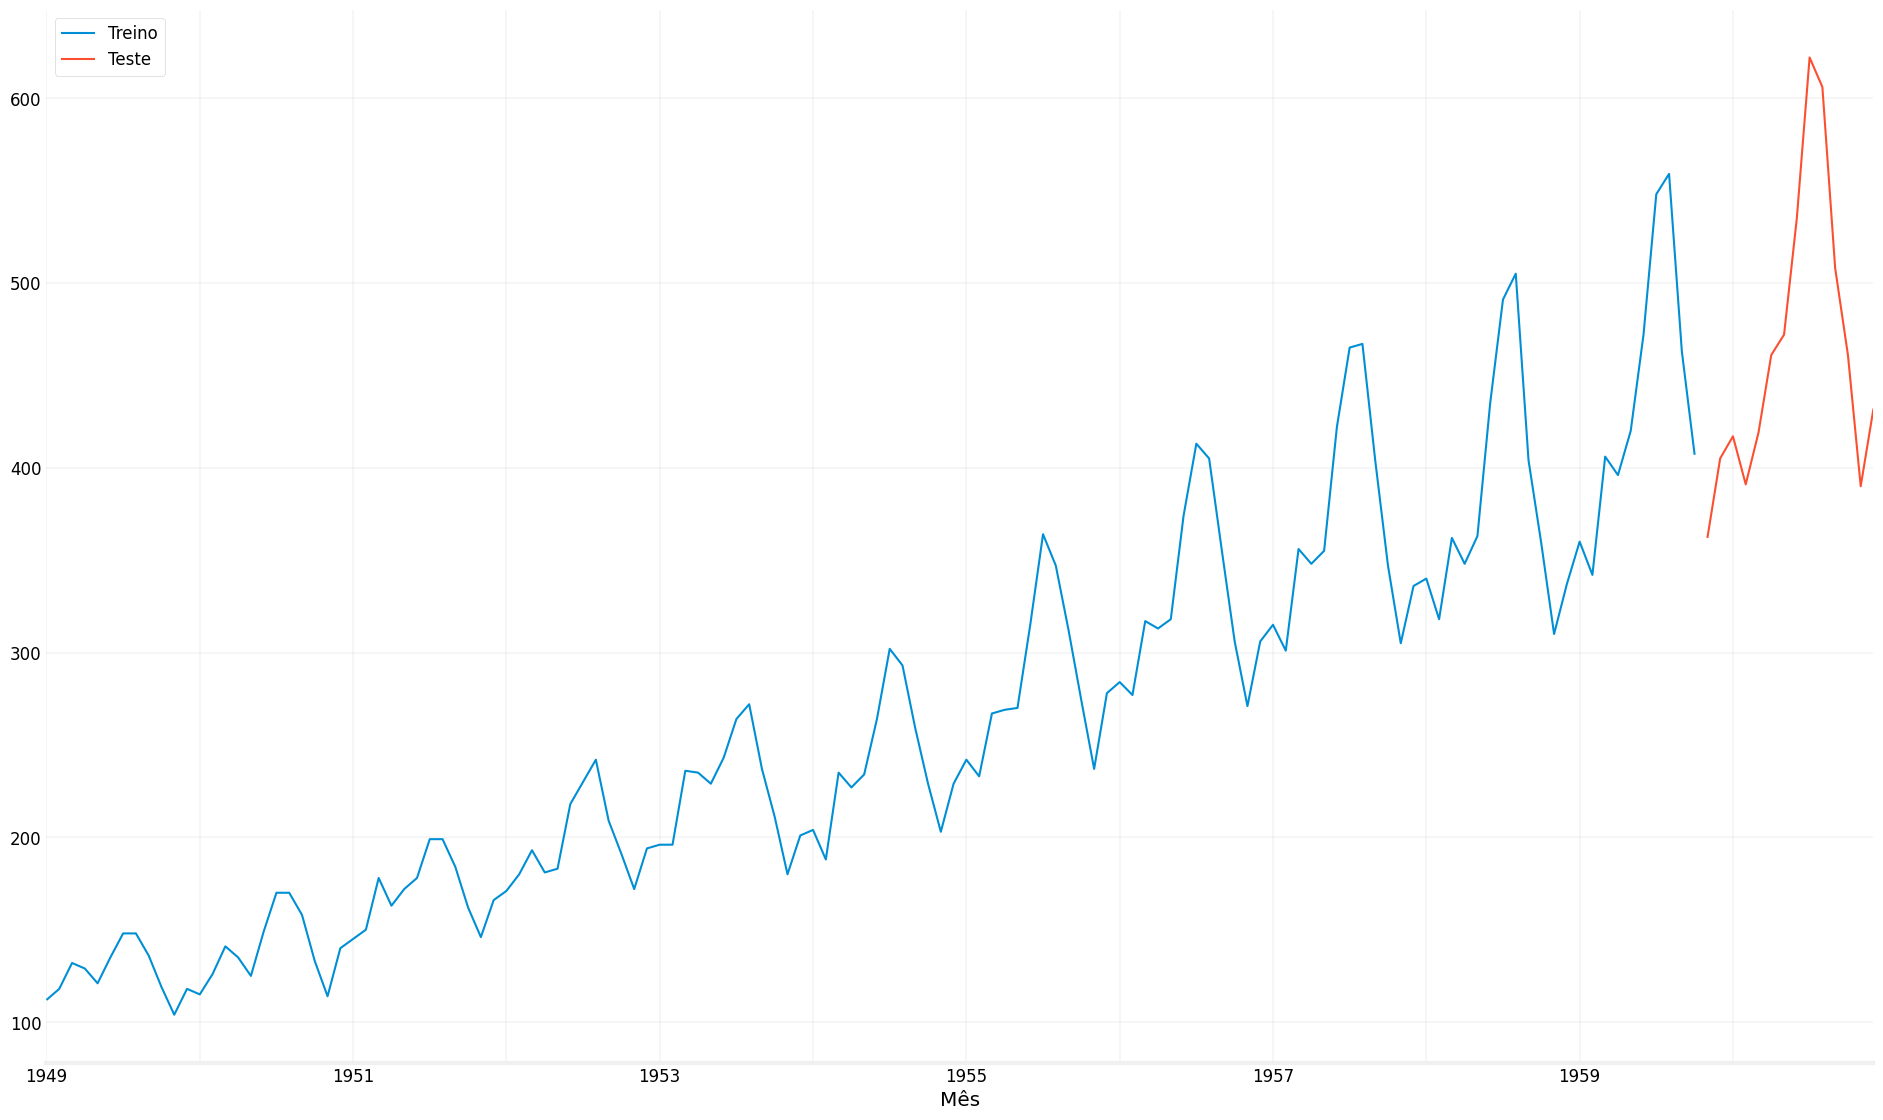

In [ ]:
# Exibe a série temporal, com a separação da base de dados

pd.concat([TreinoDF,TesteDF], axis = 1).plot()

#### Previsão pelo modelo SARIMA

In [ ]:
# Definição da ordem de autorregressividade
p = 2

# Definição da ordem de integração
d = 1

# Definição da ordem da média móvel
q = 2

# Definição da ordem de autorregressividade sazonal
P = 1

# Definição da ordem de integração sazonal
D = 1

# Definição da ordem da média móvel sazonal
Q = 2

# Período da sazonalidade
m = 12

In [ ]:
InstanteInicial = dt.datetime.now()
model = SARIMAX(TreinoDF, order=(p,d,q), seasonal_order = (P,D,Q,m))
model_fit = model.fit()
InstanteFinal = dt.datetime.now()

C:\Users\leopo\.conda\envs\PUCminas\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leopo\.conda\envs\PUCminas\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leopo\.conda\envs\PUCminas\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(f'Tempo gasto com o modelo SARIMA: {str(InstanteFinal - InstanteInicial)}')

Tempo gasto com o modelo SARIMA: 0:00:05.078268


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Treino   No. Observations:                  130
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -431.904
Date:                            Mon, 10 Mar 2025   AIC                            879.808
Time:                                    01:43:10   BIC                            901.905
Sample:                                01-01-1949   HQIC                           888.779
                                     - 10-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3655      0.312      1.172      0.241      -0.246       0.977
ar.L2          0.4339      0.210      2.062      0.039       0.022       0.846
ma.L1         -0.7162      0.423     -1.694      0.090      -1.545       0.112
ma.L2         -0.2630      0.255     -1.030      0.303      -0.764       0.238
ar.S.L12       0.9981      0.191      5.226      0.000       0.624       1.372
ma.S.L12      -1.2703      1.797     -0.707      0.480      -4.793       2.252
ma.S.L24       0.2980      0.462      0.645      0.519      -0.607       1.203
sigma2        81.8296    134.297      0.609      0.542    -181.388     345.047
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.27
Prob(Q):                              0.89   Prob(JB):                         0.12
Heteroskedasticity (H):               1.45   Skew:                            -0.22
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

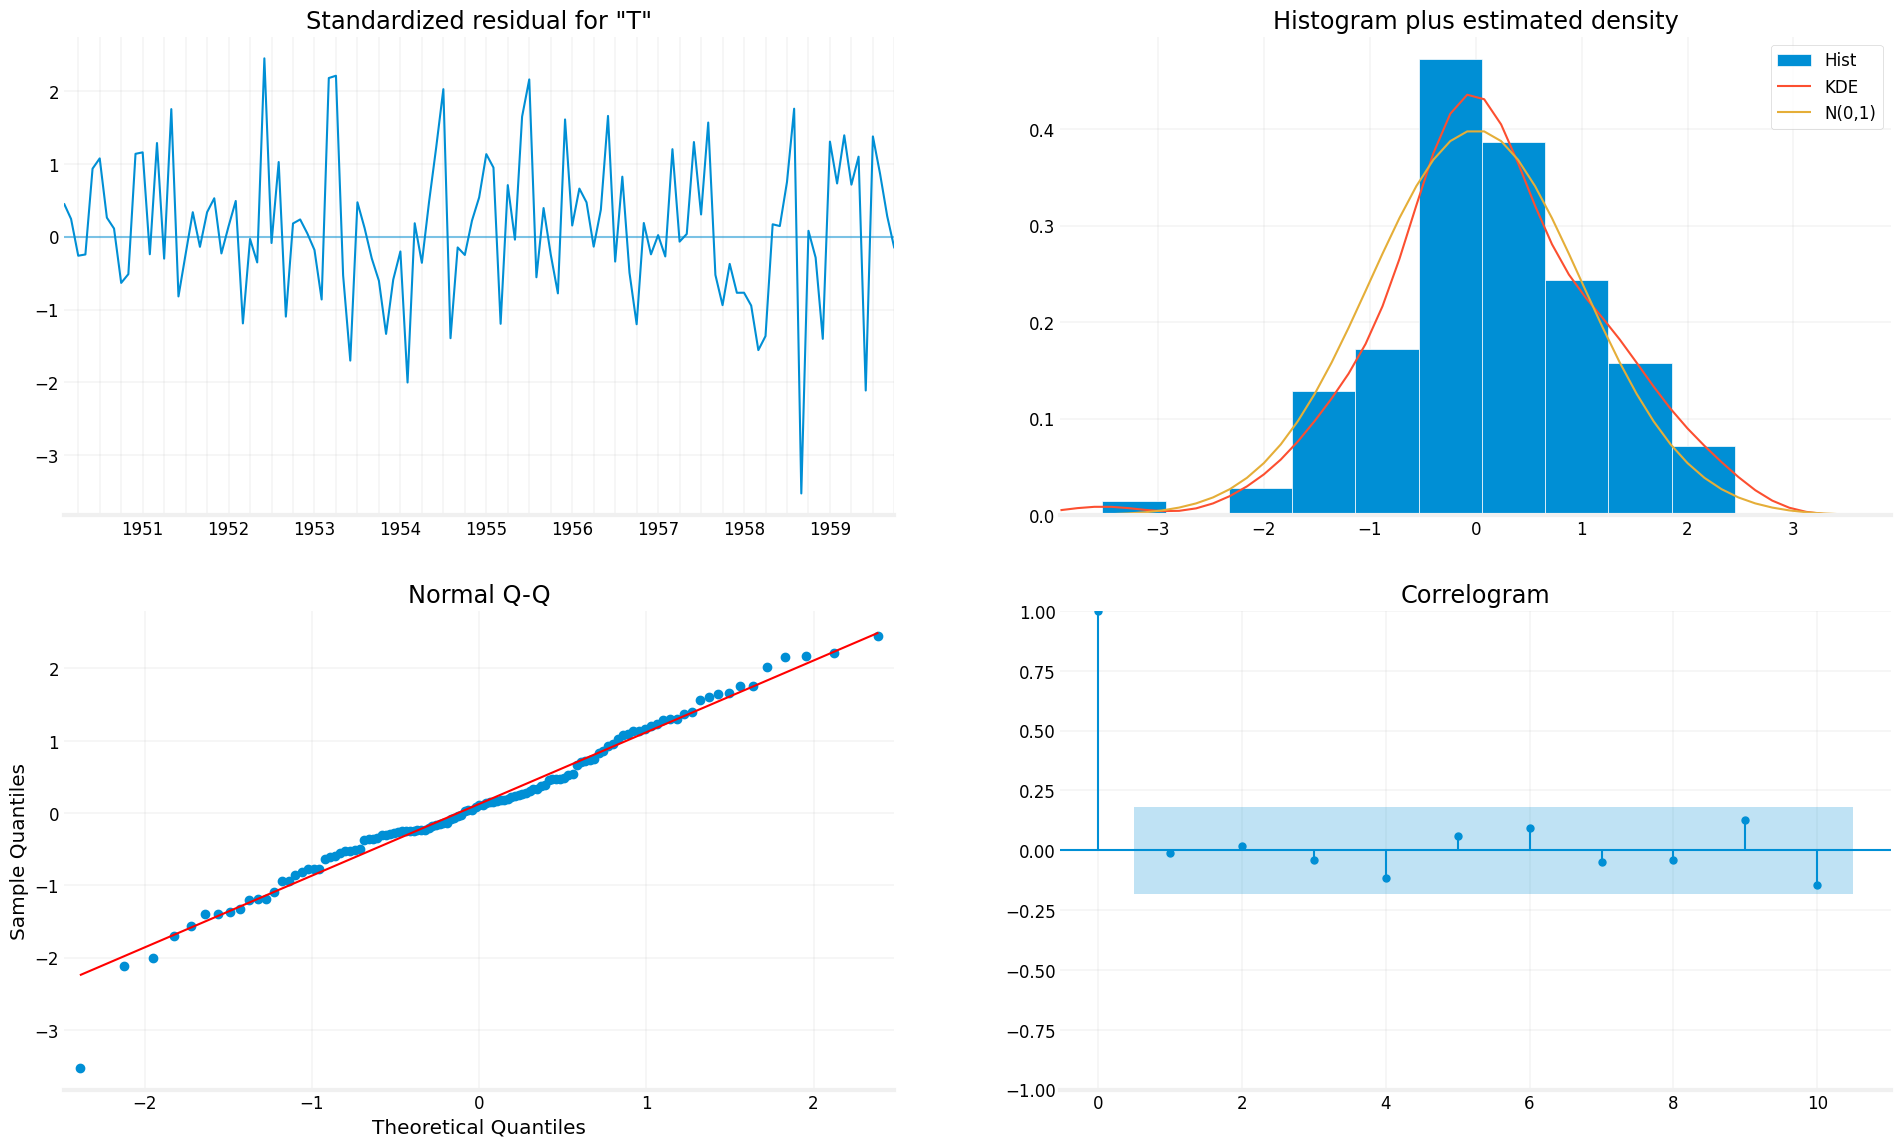

In [ ]:
model_fit.plot_diagnostics();

In [ ]:
PrevisoesSARIMAX = model_fit.get_prediction(len(TreinoDF), len(TreinoDF) + len(TesteDF) - 1).predicted_mean

In [ ]:
# Montagem do DataFrame de previsão

PrevisoesDF  = pd.DataFrame(index = MinhaSerieTemporal[-PeriodoTeste:].index)
PrevisoesDF['Previsão'] = PrevisoesSARIMAX

<Axes: xlabel='Mês'>

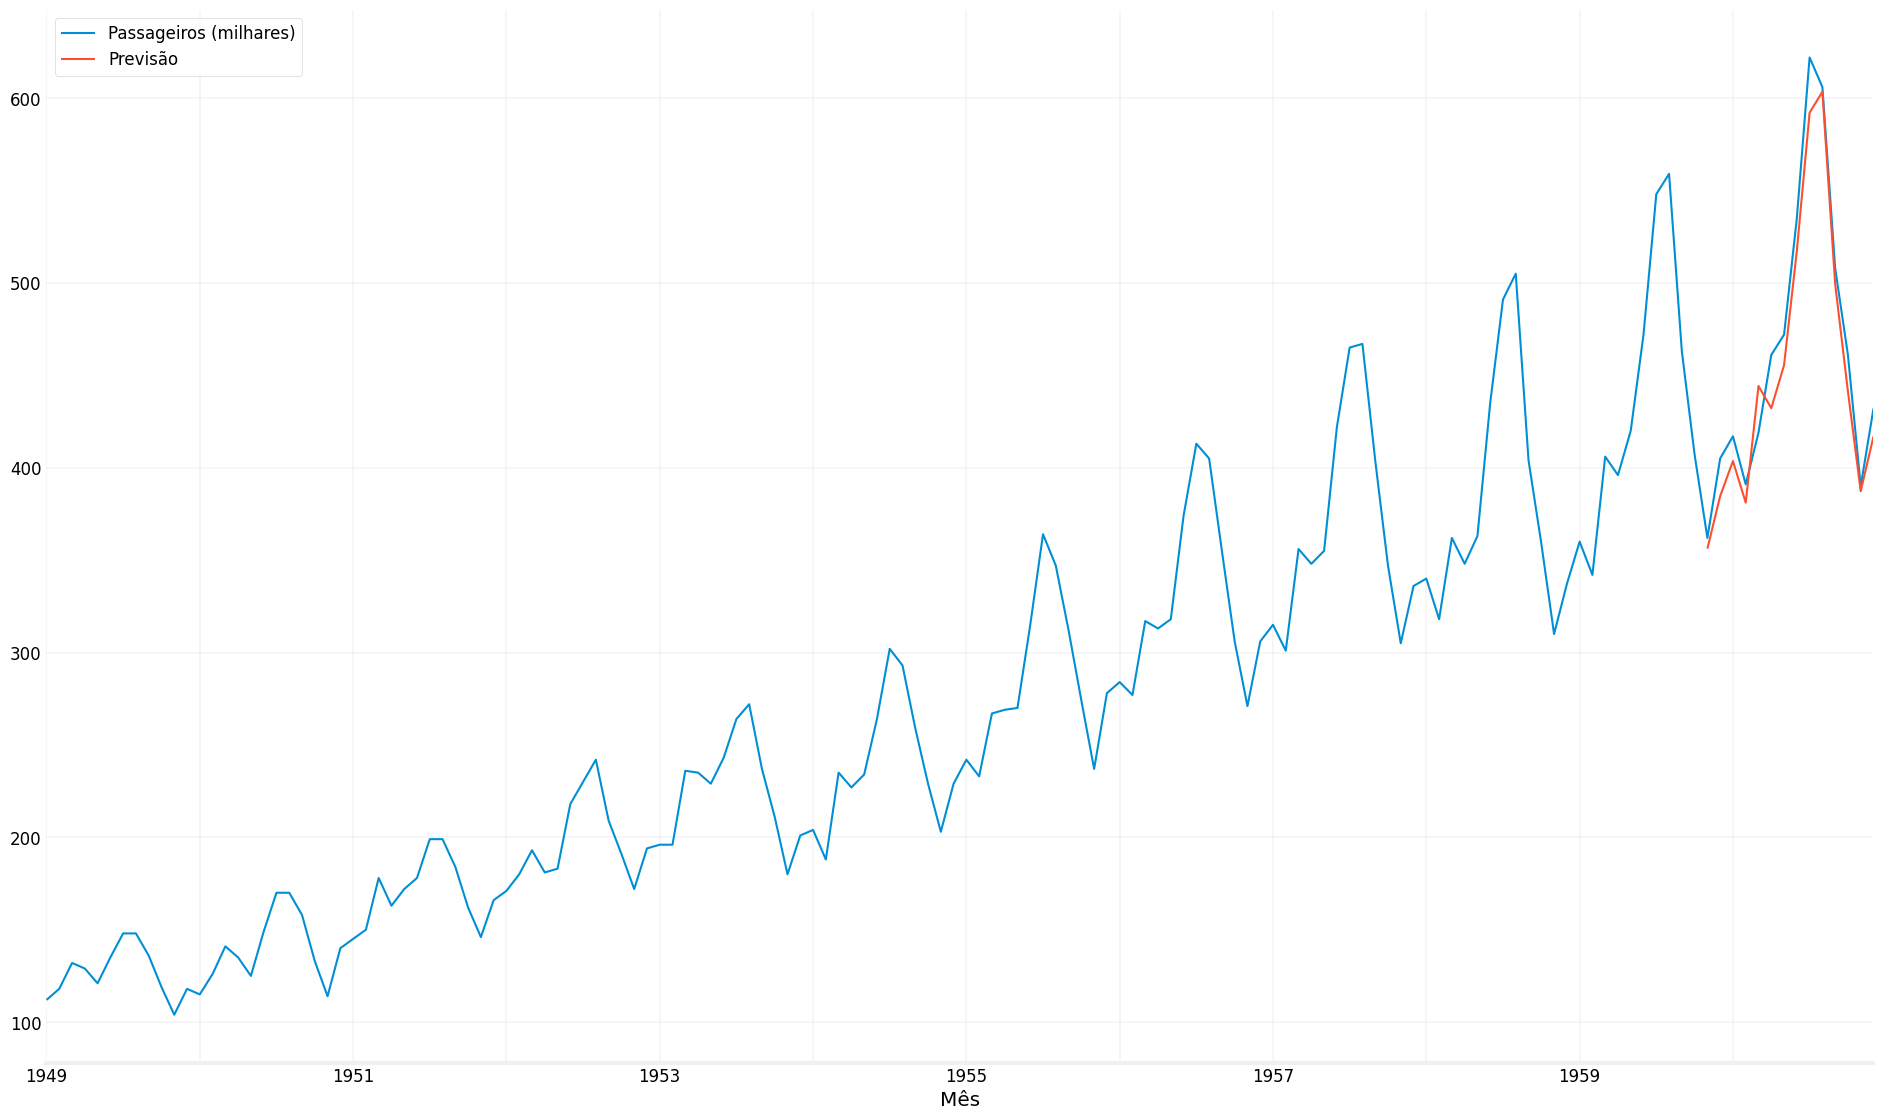

In [ ]:
# Exibe a série temporal, com a separação da base de dados

pd.concat([MinhaSerieTemporal,PrevisoesDF], axis = 1).plot()

#### Medidas de erro

In [ ]:
# Cáluclo do vetor de erros

Erros = PrevisoesDF['Previsão'].values - TesteDF['Teste'].values
Erros

array([ -5.81511691, -20.36137682, -13.40771388,  -9.90196837,
        25.20295958, -28.79373165, -16.53798734, -17.69348986,
       -29.91398212,  -2.57675814,  -8.65936724, -19.73627236,
        -2.72229915, -15.11197324])

In [ ]:
# Cálculo do erro médio
ErroMedio = Erros.mean()

In [ ]:
# Cálculo do erro absoluto médio
MAE = np.abs(Erros).mean()

In [ ]:
# Cálculo da raiz do erro quadrático médio
RMSE = np.sqrt((Erros**2).mean())

In [ ]:
# Cálculo dos erros relativos
ErrosRelativos = Erros / TesteDF['Teste'].values
ErrosRelativos

array([-0.01606386, -0.050275  , -0.03215279, -0.02532473,  0.06015026,
       -0.06245929, -0.03503811, -0.03307194, -0.04809322, -0.00425208,
       -0.017046  , -0.04281187, -0.00698025, -0.03498142])

In [ ]:
# Cálculo do erro percentual absoluto médio
MAPE = np.abs(ErrosRelativos).mean()

In [ ]:
print(f'Medidas de erro de previsão')
print()
print(f'Modelo de previsão: SARIMA({p},{d},{q})({P},{D},{Q}){m}')
print()
print(f'Erro médio: {ErroMedio: 2.1f}')
print(f'MAE:        {MAE: 2.1f}')
print(f'RMSE:       {RMSE: 2.1f}')
print(f'MAPE:       {MAPE*100: 2.1f} %')

Medidas de erro de previsão

Modelo de previsão: SARIMA(2,1,2)(1,1,2)12

Erro médio: -11.9
MAE:         15.5
RMSE:        17.7
MAPE:        3.3 %
